In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

In [2]:
# CSV 파일 로딩

df = pd.read_csv('../data/PointHistory_201809_rev.csv')
df.head()

,Time,SP,PV,OUT
0,2018.09.03 00:00:00.000,20.0,26.423,0.0
1,2018.09.03 00:01:00.000,20.0,26.422,0.0
2,2018.09.03 00:02:00.000,20.0,26.424,0.0
3,2018.09.03 00:03:00.000,20.0,26.427,0.0
4,2018.09.03 00:04:00.000,20.0,26.426,0.0


In [3]:
def get_timeblock_series1(signal_data, given=522, pred=14):
    dataX, dataY, dataL = [], [], []
    for i in range(len(signal_data)-(given+pred)):
        dataX.append(signal_data[i:(i+given), :])    # [PV, out]
        dataY.append(signal_data[i+given+1:i+given+pred+1, :])
        dataL.append(signal_data[i+given+1:i+given+pred, :])

    return np.array(dataX), np.array(dataY), np.array(dataL)

def get_timeblock_series2(signal_data, given=522, pred=14):
    dataX, dataY = [], []
    for i in range(len(signal_data)-(given+pred)):
        dataX.append(signal_data[i:(i+given), 0:1])    # [PV]
        dataY.append(signal_data[i+given+1:i+given+pred+1, 0:1])

    return np.array(dataX), np.array(dataY)

def transform_series_encode(series_array):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

In [4]:
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Activation, Dropout, Lambda, Multiply, Add, Concatenate
from keras.optimizers import Adam

# convolutional operation parameters
n_filters = 32 # 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] * 2 

# define an input history series and pass it through a stack of dilated causal convolution blocks. 
history_seq = Input(shape=(None, 2))
x = history_seq

skips = []
for dilation_rate in dilation_rates:
    
    # preprocessing - equivalent to time-distributed dense
    x = Conv1D(16, 1, padding='same', activation='relu')(x) 
    
    # filter convolution
    x_f = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # gating convolution
    x_g = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # multiply filter and gating branches
    z = Multiply()([Activation('tanh')(x_f),
                    Activation('sigmoid')(x_g)])
    
    # postprocessing - equivalent to time-distributed dense
    z = Conv1D(16, 1, padding='same', activation='relu')(z)
    
    # residual connection
    x = Add()([x, z])    
    
    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = Activation('relu')(Add()(skips))

# final time-distributed dense layers 
out = Conv1D(128, 1, padding='same')(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(1, 1, padding='same')(out)

# extract the last 60 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]

pred_seq_train = Lambda(slice, arguments={'seq_length':60})(out)

model = Model(history_seq, pred_seq_train)
model.compile(Adam(), loss='mean_absolute_error')

/home/kohangyu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [5]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 2)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 16)     48          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, None, 32)     1056        conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, None, 32)     1056        conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation

In [8]:
# 데이터 로딩

data = df.iloc[:, 2:4].values

train_data = data[:10920]
test_data = data[10920:]

look_back = 430

x_train, y_train, l_train = get_timeblock_series1(train_data[:-look_back], given=430, pred=60)
x_test, y_test, l_test = get_timeblock_series1(test_data[:-look_back], given=430, pred=60)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# x_train = x_train.reshape(x_train.shape[0], x_train.shape[1])
# y_train = y_train.reshape(y_train.shape[0], y_train.shape[1])
# print(x_train.shape)
# print(y_train.shape)

# encoder_input_data, encode_series_mean = transform_series_encode(x_train)
# decoder_target_data = transform_series_decode(y_train, encode_series_mean)
# lagged_target_history = decoder_target_data[:, :-1, :1]
# encoder_input_data = np.concatenate([encoder_input_data, lagged_target_history], axis=1)

encoder_input_data = x_train / 100.0
decoder_target_data = y_train / 100.0
lagged_target_history = l_train / 100.0
encoder_input_data = np.concatenate([encoder_input_data, lagged_target_history], axis=1)

# for y_train, [pv, out] --> [pv]
decoder_target_data = np.array(np.split(np.array(decoder_target_data), 2, axis=2))[0]

print(encoder_input_data.shape)
print(decoder_target_data.shape)
# print(lagged_target_history.shape)

(10000, 430, 2) (10000, 60, 2)
(497, 430, 2) (497, 60, 2)
(10000, 489, 2)
(10000, 60, 1)


In [9]:
batch_size = 2**10 # 2**11 --> OOM error
epochs = 1000

model.compile(Adam(), loss='mean_absolute_error')
history = model.fit(encoder_input_data, decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/1000
8000/8000 [==============================] - 9s 1ms/step - loss: 0.0379 - val_loss: 0.0034
Epoch 2/1000
8000/8000 [==============================] - 6s 748us/step - loss: 0.0293 - val_loss: 0.0126
Epoch 3/1000
8000/8000 [==============================] - 6s 748us/step - loss: 0.0248 - val_loss: 0.0180
Epoch 4/1000
8000/8000 [==============================] - 6s 749us/step - loss: 0.0221 - val_loss: 0.0143
Epoch 5/1000
8000/8000 [==============================] - 6s 752us/step - loss: 0.0202 - val_loss: 0.0098
Epoch 6/1000
8000/8000 [==============================] - 6s 748us/step - loss: 0.0189 - val_loss: 0.0104
Epoch 7/1000
8000/8000 [==============================] - 6s 750us/step - loss: 0.0177 - val_loss: 0.0119
Epoch 8/1000
8000/8000 [==============================] - 6s 751us/step - loss: 0.0168 - val_loss: 0.0104
Epoch 9/1000
8000/8000 [==============================] - 6s 751us/step - loss: 0.0160 - val_loss: 0.0088


8000/8000 [==============================] - 6s 760us/step - loss: 0.0014 - val_loss: 0.0037
Epoch 154/1000
8000/8000 [==============================] - 6s 759us/step - loss: 0.0013 - val_loss: 0.0022
Epoch 155/1000
8000/8000 [==============================] - 6s 762us/step - loss: 0.0012 - val_loss: 0.0034
Epoch 156/1000
8000/8000 [==============================] - 6s 754us/step - loss: 0.0014 - val_loss: 0.0035
Epoch 157/1000
8000/8000 [==============================] - 6s 766us/step - loss: 0.0014 - val_loss: 0.0035
Epoch 158/1000
8000/8000 [==============================] - 6s 788us/step - loss: 0.0013 - val_loss: 0.0040
Epoch 159/1000
8000/8000 [==============================] - 6s 758us/step - loss: 0.0014 - val_loss: 0.0029
Epoch 160/1000
8000/8000 [==============================] - 6s 750us/step - loss: 0.0016 - val_loss: 0.0046
Epoch 161/1000
8000/8000 [==============================] - 6s 762us/step - loss: 0.0019 - val_loss: 0.0056
Epoch 162/1000
8000/8000 [=================

Epoch 229/1000
8000/8000 [==============================] - 6s 763us/step - loss: 0.0011 - val_loss: 0.0035
Epoch 230/1000
8000/8000 [==============================] - 6s 748us/step - loss: 0.0010 - val_loss: 0.0026
Epoch 231/1000
8000/8000 [==============================] - 6s 747us/step - loss: 0.0013 - val_loss: 0.0029
Epoch 232/1000
8000/8000 [==============================] - 6s 751us/step - loss: 0.0012 - val_loss: 0.0028
Epoch 233/1000
8000/8000 [==============================] - 6s 756us/step - loss: 0.0011 - val_loss: 0.0029
Epoch 234/1000
8000/8000 [==============================] - 6s 762us/step - loss: 0.0010 - val_loss: 0.0032
Epoch 235/1000
8000/8000 [==============================] - 6s 758us/step - loss: 0.0010 - val_loss: 0.0034
Epoch 236/1000
8000/8000 [==============================] - 6s 773us/step - loss: 0.0011 - val_loss: 0.0034
Epoch 237/1000
8000/8000 [==============================] - 6s 754us/step - loss: 0.0011 - val_loss: 0.0023
Epoch 238/1000
8000/8000 [==

8000/8000 [==============================] - 6s 753us/step - loss: 8.8175e-04 - val_loss: 0.0015
Epoch 379/1000
8000/8000 [==============================] - 6s 755us/step - loss: 9.0193e-04 - val_loss: 0.0027
Epoch 380/1000
8000/8000 [==============================] - 6s 755us/step - loss: 8.9310e-04 - val_loss: 0.0026
Epoch 381/1000
8000/8000 [==============================] - 6s 756us/step - loss: 9.6656e-04 - val_loss: 0.0019
Epoch 382/1000
8000/8000 [==============================] - 6s 752us/step - loss: 9.5748e-04 - val_loss: 0.0024
Epoch 383/1000
8000/8000 [==============================] - 6s 753us/step - loss: 8.9058e-04 - val_loss: 0.0026
Epoch 384/1000
8000/8000 [==============================] - 6s 753us/step - loss: 0.0011 - val_loss: 0.0026
Epoch 385/1000
8000/8000 [==============================] - 6s 753us/step - loss: 9.8260e-04 - val_loss: 0.0032
Epoch 386/1000
8000/8000 [==============================] - 6s 752us/step - loss: 9.4801e-04 - val_loss: 0.0023
Epoch 387/1

8000/8000 [==============================] - 6s 753us/step - loss: 9.1460e-04 - val_loss: 0.0017
Epoch 525/1000
8000/8000 [==============================] - 6s 753us/step - loss: 8.6085e-04 - val_loss: 0.0025
Epoch 526/1000
8000/8000 [==============================] - 6s 755us/step - loss: 8.4754e-04 - val_loss: 0.0026
Epoch 527/1000
8000/8000 [==============================] - 6s 755us/step - loss: 7.9980e-04 - val_loss: 0.0022
Epoch 528/1000
8000/8000 [==============================] - 6s 752us/step - loss: 9.5343e-04 - val_loss: 0.0015
Epoch 529/1000
8000/8000 [==============================] - 6s 755us/step - loss: 0.0011 - val_loss: 0.0022
Epoch 530/1000
8000/8000 [==============================] - 6s 754us/step - loss: 9.6499e-04 - val_loss: 0.0020
Epoch 531/1000
8000/8000 [==============================] - 6s 753us/step - loss: 9.3107e-04 - val_loss: 0.0026
Epoch 532/1000
8000/8000 [==============================] - 6s 752us/step - loss: 8.8317e-04 - val_loss: 0.0030
Epoch 533/1

Epoch 671/1000
8000/8000 [==============================] - 6s 779us/step - loss: 8.4591e-04 - val_loss: 0.0020
Epoch 672/1000
8000/8000 [==============================] - 6s 771us/step - loss: 8.8479e-04 - val_loss: 0.0029
Epoch 673/1000
8000/8000 [==============================] - 6s 780us/step - loss: 8.9116e-04 - val_loss: 0.0022
Epoch 674/1000
8000/8000 [==============================] - 6s 764us/step - loss: 8.3828e-04 - val_loss: 0.0020
Epoch 675/1000
8000/8000 [==============================] - 6s 765us/step - loss: 8.3990e-04 - val_loss: 0.0027
Epoch 676/1000
8000/8000 [==============================] - 6s 751us/step - loss: 9.0190e-04 - val_loss: 0.0021
Epoch 677/1000
8000/8000 [==============================] - 6s 770us/step - loss: 8.4644e-04 - val_loss: 0.0024
Epoch 678/1000
8000/8000 [==============================] - 6s 764us/step - loss: 8.9603e-04 - val_loss: 0.0031
Epoch 679/1000
8000/8000 [==============================] - 6s 766us/step - loss: 8.3160e-04 - val_loss:

8000/8000 [==============================] - 6s 754us/step - loss: 7.9243e-04 - val_loss: 0.0018
Epoch 818/1000
8000/8000 [==============================] - 6s 754us/step - loss: 7.5820e-04 - val_loss: 0.0019
Epoch 819/1000
8000/8000 [==============================] - 6s 753us/step - loss: 7.7675e-04 - val_loss: 0.0026
Epoch 820/1000
8000/8000 [==============================] - 6s 753us/step - loss: 7.4456e-04 - val_loss: 0.0026
Epoch 821/1000
8000/8000 [==============================] - 6s 750us/step - loss: 7.8866e-04 - val_loss: 0.0020
Epoch 822/1000
8000/8000 [==============================] - 6s 753us/step - loss: 7.0348e-04 - val_loss: 0.0025
Epoch 823/1000
8000/8000 [==============================] - 6s 751us/step - loss: 8.3790e-04 - val_loss: 0.0029
Epoch 824/1000
8000/8000 [==============================] - 6s 751us/step - loss: 8.4849e-04 - val_loss: 0.0024
Epoch 825/1000
8000/8000 [==============================] - 6s 753us/step - loss: 9.2637e-04 - val_loss: 0.0025
Epoch 8

8000/8000 [==============================] - 6s 752us/step - loss: 6.8893e-04 - val_loss: 0.0023
Epoch 964/1000
8000/8000 [==============================] - 6s 754us/step - loss: 8.0835e-04 - val_loss: 0.0023
Epoch 965/1000
8000/8000 [==============================] - 6s 751us/step - loss: 9.3240e-04 - val_loss: 0.0028
Epoch 966/1000
8000/8000 [==============================] - 6s 750us/step - loss: 8.2566e-04 - val_loss: 0.0022
Epoch 967/1000
8000/8000 [==============================] - 6s 751us/step - loss: 7.9514e-04 - val_loss: 0.0016
Epoch 968/1000
8000/8000 [==============================] - 6s 752us/step - loss: 7.8394e-04 - val_loss: 0.0027
Epoch 969/1000
8000/8000 [==============================] - 6s 752us/step - loss: 7.5280e-04 - val_loss: 0.0027
Epoch 970/1000
8000/8000 [==============================] - 6s 754us/step - loss: 7.4534e-04 - val_loss: 0.0024
Epoch 971/1000
8000/8000 [==============================] - 6s 753us/step - loss: 6.8842e-04 - val_loss: 0.0019
Epoch 9

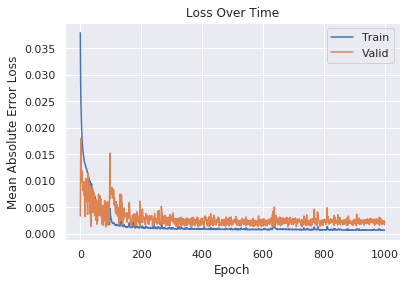

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [11]:
def predict_sequence(input_sequence, valve_sequence):

    history_sequence = input_sequence.copy()
    pred_sequence = np.zeros((1,pred_steps,1)) # initialize output (pred_steps time steps)  
    
    for i in range(pred_steps):
        
        # record next time step prediction (last time step of model output) 
        last_step_pred = model.predict(history_sequence)[0,-1,0]
        pred_sequence[0,i,0] = last_step_pred
        
        # [pred_pv, out]
        last_sequence = np.array([last_step_pred, valve_sequence[0,i,0]])
        
        # add the next time step prediction to the history sequence
        history_sequence = np.concatenate([history_sequence, last_sequence.reshape(-1, 1, 2)], axis=1)
                                           #last_step_pred.reshape(-1,1,1)], axis=1)

    return pred_sequence

In [12]:
# 테스트 데이터 셋 생성

# x_test = x_test.reshape(x_test.shape[0], x_test.shape[1])
# y_test = y_test.reshape(y_test.shape[0], y_test.shape[1])
# print(x_test.shape)
# print(y_test.shape)

# encoder_input_data, encode_series_mean = transform_series_encode(x_test)
# decoder_target_data = transform_series_decode(y_test, encode_series_mean)

# encoder_input_data = x_test / 100.0
# decoder_target_data = y_test / 100.0

encoder_input_data = x_train / 100.0
decoder_target_data = y_train / 100.0

decoder_target_temp = np.array(np.split(np.array(decoder_target_data), 2, axis=2))[0]
decoder_target_valve = np.array(np.split(np.array(decoder_target_data), 2, axis=2))[1]

print(encoder_input_data.shape)
print(decoder_target_temp.shape)
print(decoder_target_valve.shape)

(10000, 430, 2)
(10000, 60, 1)
(10000, 60, 1)


In [13]:
pred_steps = 60
def predict_and_plot(encoder_input_data, decoder_target_temp, decoder_target_valve, sample_ind, enc_tail_len=50):

    encode_series = encoder_input_data[sample_ind:sample_ind+1,:,:] 
    pred_series = predict_sequence(encode_series, decoder_target_valve[sample_ind:sample_ind+1,:,:])
    
    # for plotting, [pv, out] --> [pv]
    encode_series = np.array(np.split(np.array(encode_series), 2, axis=2))[0]
    
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ind,:,:1].reshape(-1,1) 
    
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    encode_series_tail = encode_series_tail * 100.0
    target_series = target_series * 100.0
    pred_series = pred_series * 100.0
    
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])

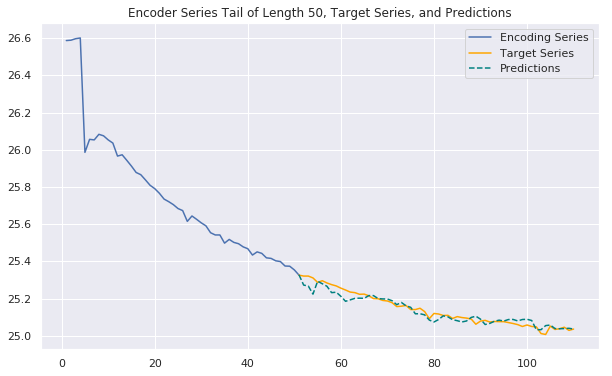

In [17]:
predict_and_plot(encoder_input_data, decoder_target_temp, decoder_target_valve, 10)

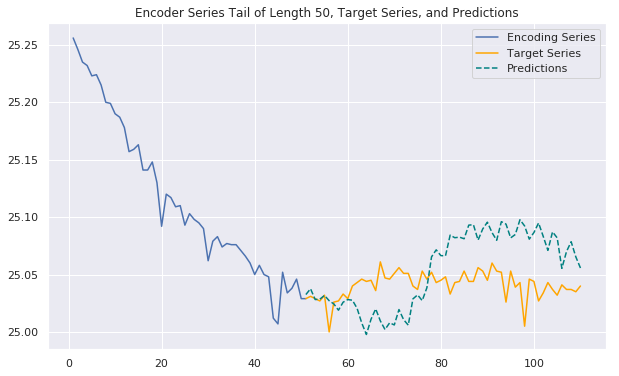

In [20]:
predict_and_plot(encoder_input_data, decoder_target_temp, decoder_target_valve, 70)

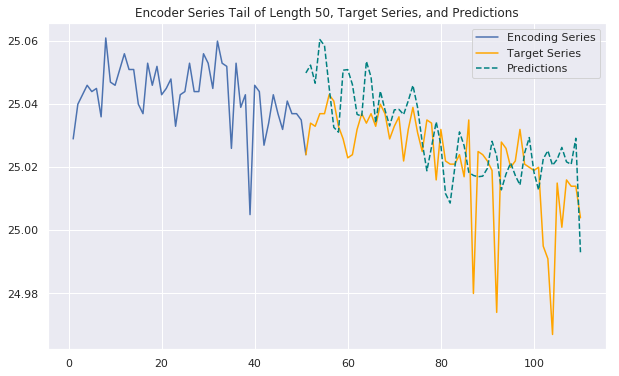

In [21]:
predict_and_plot(encoder_input_data, decoder_target_temp, decoder_target_valve, 130)

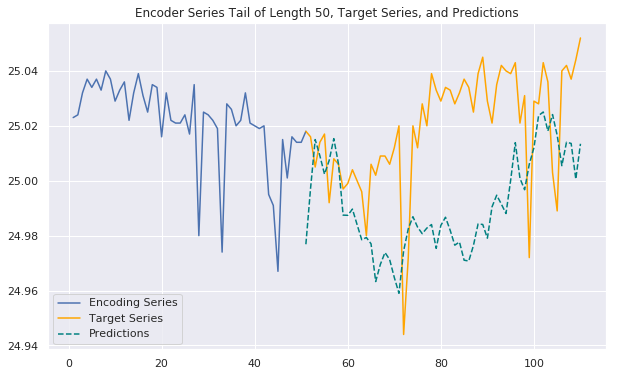

In [22]:
predict_and_plot(encoder_input_data, decoder_target_temp, decoder_target_valve, 190)

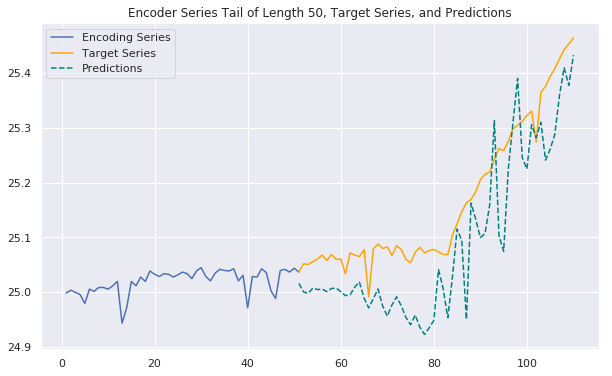

In [23]:
predict_and_plot(encoder_input_data, decoder_target_temp, decoder_target_valve, 250)